# New Jersey News Cleanup

## Matthew Bone

## Vision

This project is a preliminary cleanup of the data that is to be used in a research project by Professor Holcomb from the English department. Professor Holcomb is teaming up with a group at Montclair State's Center for Cooperative Media to map the local news ecosystem of New Jersey. In particular, they want to use this dataset to map the geographic spread of news stories in the state. They collected this data in partnership with the Internet Archive by scraping all of the text data from over 700 news sites in New Jersey, including social media such as Facebook and Twitter. However, during this web scraping, many unuseable webpages were scraped. For instance, there are Facebook login pages and "About Us" pages from news sites. Therefore, in this project I try to create a classifier that will be able to separate the useable data from the unuseable data. In previous projects for my AWS class and DATA 303, I've worked in a group to clean up the data and label 3000 documents as either an article or a nonarticle. Additionally, we created a few preliminary models with different architectures, including a bag-of-words based Logistic Regression classifier, an AWS BlazingText classifier, and a bag-of-words based Neural Net. We found that the Logistic Regression and Neural Net classifiers performed the best and the Neural Net generally had better positive recall, an important metric. Therefore, I'm continuing that work by trying to find the best approach to developing a bag-of-words based Neural Net classifier. 

In this project I'm particularly interested in overcoming two problems. One is that the performance of these classifiers was significantly worse for predicting articles than nonarticles. In other words, it had a relatively low positive recall rate and an okay negative recall rate. This is because only about 23% of the data is articles. The second problem is that we haven't utilized the domain or url features of this data at all. I'd like to determine if either of these would be useful in predicting whether or not an entry is an article. I decided to use neural nets because while comparing them to the Logistic Regression and BlazingText Classifiers in our previous projects, they performed significantly better overall than the BlazingText Classifier and seemed to have better positive recall rates than the Logistic Regression models. 

Therefore, in this project I try four different ways to correct for the imbalanced classes in the data and I add URL and domain features to see if the neural net classifiers improve. 

## Background

I will be extracting features from the text data using sklearn's CountVectorizer which produces a bag-of-words vectorization for each document where each index in the vector is associated with a word and the value is the count of occurences of that word in the document (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). I wanted to use this rather than a one-hot-encoding because I would expect full length articles to have many more full sentences and to contain high quantities of the vocabulary that is characteristic of such sentences. Additionally, in a previous project we compared this bag-of-words approach to AWS's Blazing Text classifier (a pretrained word2vec embedding) and found that bag-of-words approachs worked much better. 

I'm planning to use Keras's sequential neural nets to perform this classification. The architecture reflects the ones we built in class for the mnist dataset (https://github.com/kvlinden-courses/cs344-code/blob/master/u08features/keras-mnist.ipynb) but I will test many different parameterizations. I want to develop a model that has a high positive recall rate. In order to do this, I will implement a few different techniques for dealing with minority classes in training models. I've taken this list of techniques from EliteDataScience.com's article on imbalanced classes (https://elitedatascience.com/imbalanced-classes). These techniques include:

- Up-Sampling the minority class
- Down-Sampling the majority class
- Changing the Performance Metric
- Cost-Sensitive Training

I chose to incorporate Domain and URL features by using sklearn's CountVectorizer on them and appending their vectorizations onto the document vectorizations. The vectorization separated words by non-letter characters like . or /. I display some of the resulting vocabulary below. My hope was that different domains would be likely to have different vocabulary that indicate whether or not they're an article and that the nerual net would be able to pick up on this interaction. For the urls, many of them will include words like "login" that I hope will be strong indicators of them not being articles.  

The basic tools I'm using for this project are relatively simple, however, I create many helper functions to perform a more robust comparison between these different approaches. The most important method is to peform a grid-search using a large number of different parameterizations. This allows me to compare the different model groups since each individual model is highly sensitive to the randomness introduced while training. 


## Implementation
### Preproccessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import regularizers
from keras.losses import BinaryCrossentropy
from keras.metrics import Recall
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import hstack
import keras.backend as K

Using TensorFlow backend.


In [18]:
filtered = pd.read_csv("filtered_news.csv").sort_values('Unnamed: 0')
filtered.index = filtered['Unnamed: 0']
del filtered['Unnamed: 0']
filtered.index.names = ["index"]
display(filtered)
filtered.to_csv("filtered_news.csv")

,date,domain,url,text,is_article,politics,community
index,,,,,,,
0,2019-10-20,thesunpapers.com,https://thesunpapers.com/2015/02/?amp,February 2015 - The Sun Newspapers Towns Berli...,0,0,0
1,2019-10-24,www.pressofatlanticcity.com,https://www.pressofatlanticcity.com/news/galle...,GALLERY: Galloway Township National Night Out ...,0,0,0
2,2019-11-02,www.tapinto.net,https://www.tapinto.net/towns/bloomfield/secti...,Bloomfield NJ Community Announcements Section ...,0,0,0
3,2019-10-30,www.newjerseyhills.com,https://www.newjerseyhills.com/hunterdon_revie...,Bestselling author Stedman Graham will speak a...,1,0,1
4,2019-10-13,www.asianjournal.com,https://www.asianjournal.com/usa/california/fi...,Fil-Am Rep. TJ Cox sworn in to represent Calif...,1,1,0
...,...,...,...,...,...,...,...
6793,2019-10-24,www.towntopics.com,http://www.towntopics.com/wordpress/readers-ch...,Readers’ Choice Awards Results Town Topics Me...,0,0,0
6794,2019-10-25,njnews.web.franklyinc.com,http://njnews.web.franklyinc.com/story/4117994...,How a 3D Rendering Leads to a Fast Home Sale -...,0,0,0
6795,2019-10-26,patch.com,https://patch.com/new-jersey/hasbrouckheights/...,Big Multi Family Yard Sale 10/12 & 10/13 - Has...,0,0,0


In [3]:
unlabeled = pd.read_csv("unlabeled.csv", error_bad_lines = False, header = None)
unlabeled = unlabeled.reset_index(drop = True)
unlabeled = unlabeled.rename(columns = {0:'date', 1:'domain', 2:'url', 3:'text'})
unlabeled['is_article'] = 0
unlabeled['politics'] = 0
unlabeled['community'] = 0
unlabeled["date"] = pd.to_datetime(unlabeled["date"], format = "%Y%m%d")

In [4]:
print(len(unlabeled))
display(unlabeled.head())

9705


,date,domain,url,text,is_article,politics,community
0,2019-10-20,thesunpapers.com,https://thesunpapers.com/2015/02/?amp,February 2015 - The Sun Newspapers Towns Berli...,0,0,0
1,2019-11-02,www.reddit.com,https://www.reddit.com/r/golf/,Golf Press J to jump to the feed. Press questi...,0,0,0
2,2019-10-24,www.pressofatlanticcity.com,https://www.pressofatlanticcity.com/news/galle...,GALLERY: Galloway Township National Night Out ...,0,0,0
3,2019-10-25,www.facebook.com,https://www.facebook.com/login/?next=https%3A%...,Log into Facebook Facebook Jump to Sections o...,0,0,0
4,2019-10-08,hi-in.facebook.com,https://hi-in.facebook.com/?_fb_noscript=1,Facebook - लॉग इन या साइन अप करें सीधे इस पर ज...,0,0,0


In [5]:
# unlabeled["domain"].value_counts().head(60)

In [5]:
soc_media = ["twitter","facebook","pinterest","google","instagram","reddit","amazon"]

is_soc_media = unlabeled["domain"].str.contains("|".join(soc_media))
is_not_soc_media = np.logical_not(is_soc_media)

print(len(unlabeled[is_not_soc_media]))

filtered_news = unlabeled[is_not_soc_media]
filtered_news = filtered_news.reset_index(drop = True)
filtered_news.to_csv("filtered_news.csv")

6798


In [2]:
# loads the datasets, each of these were manually labeled as an article or not
label1 = pd.read_csv("label1.csv", error_bad_lines = False, header = None)
label2 = pd.read_csv("label2.csv", error_bad_lines = False, header = None)
label3 = pd.read_csv("label3.csv", error_bad_lines = False, header = None)

# combines the dataset, reindexs it, names the variables, and reformats the data
data = pd.concat([label1, label2,label3])
data = data.reset_index(drop = True)
data = data.rename(columns = {0:'date', 1:'domain', 2:'url', 3:'text',4:'is_article'})
data["date"] = pd.to_datetime(data["date"], format = "%Y%m%d")

b'Skipping line 138: expected 5 fields, saw 6\nSkipping line 484: expected 5 fields, saw 6\n'


### Exploratory Data Analysis

In [3]:
print("Total Number of Entries: ", len(data))
pd.set_option('display.max_colwidth', 100)
display(data.head())

Total Number of Entries:  2903


,date,domain,url,text,is_article
0,2019-11-02,vplayer.nbcsports.com,https://vplayer.nbcsports.com/p/BxmELC/philly_main/select/media/Zm2clWq7RM9C?autoPlay=true&ssid=...,Main Philly Player To view this site you need to have JavaScript enabled in your browser and eit...,0
1,2019-10-08,www.newjerseyhills.com,https://www.newjerseyhills.com/bernardsville_news/gallery/bernards-township-library-summer-readi...,Bernards Township Library Summer Reading Party Bernardsville News Gallery newjerseyhills.com Y...,0
2,2019-10-21,www.worldjournal.com,https://www.worldjournal.com/6572376/article-%e5%a8%81%e5%9f%ba%e5%9f%ba%e6%b5%b7%e7%81%98-%e5%8...,威基基海灘 再開精品飯店哈利普納 - 世界新聞網 網頁列印 內容來自網址: https://www.worldjournal.com/6572376/article-link/ ﻿ 繁體 简体...,1
3,2019-10-09,www.facebook.com,https://www.facebook.com/media/set/gqls/vr_persona_follow_subscribe,Facebook Jump to Sections of this page Accessibility Help Press alt + / to open this menu Facebo...,0
4,2019-10-13,www.jerseyshoreonline.com,https://www.jerseyshoreonline.com/howell/yogi-the-therapy-dog-returns-to-first-home/,Yogi The Therapy Dog Returns To First Home Jersey Shore Online News Ocean County Toms River Man...,1


In [4]:
print("Proportion of Documents that are Articles: ", len(data[data.is_article == 1]) / len(data))

Proportion of Documents that are Articles:  0.22562866000688941


In [5]:
# Input: vectorizer is a sklearn countvectorizer object, corpus is a list of text documents
# Output: returns a data frame with one column holding each word in the corpus and the other 
# with the count of occurences
def vocab_counts(vectorizer, corpus):
    vecs = vectorizer.transform(corpus)
    vocab = vectorizer.vocabulary_
    vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1])}
    count = vecs.toarray().sum(axis = 0)
    vocab_counts = pd.DataFrame(columns = ["vocab", "count"])
    vocab_counts["vocab"] = vocab.keys()
    vocab_counts.index = vocab.values()
    vocab_counts["count"] = count
    vocab_counts = vocab_counts.sort_values("count", ascending = False)
    return vocab_counts


The below metrics indicate that there are many more domains with non articles than with articles. However, since this dataset only represents 3000 entries out of millions, we can't assume that domains with no articles in this sample never have articles

In [6]:
print("Number of Unique Domains: ", len(data["domain"].unique()))
nonarticles = data[data.is_article == 0]
print("Number of Domains with Non Articles: ", len(nonarticles["domain"].unique()))
articles = data[data.is_article == 1]
print("Number of Domains with Articles: ", len(articles["domain"].unique()))

Number of Unique Domains:  542
Number of Domains with Non Articles:  470
Number of Domains with Articles:  167


In [7]:
print("Most Common Words in the Text: ")
doc_vectorizer = CountVectorizer().fit(data['text'])
doc_counts = vocab_counts(doc_vectorizer, data['text'])
doc_counts.head(10)

Most Common Words in the Text: 


,vocab,count
77189,the,62351
78016,to,40114
10957,and,31992
56559,of,31457
40431,in,29554
33241,for,20517
56401,oct,17971
56943,on,17130
49920,may,17020
54340,news,14742


I ended up not using these stop words because the word vectorizations are using word counts, not just one-hot encoding. I would expect a document with far higher occurrences of words like "the" and "to" would be more likely to be articles than log in pages.

In [8]:
doc_stops = ["the","to","and","of","in","for","on"]
print("Stop Words for Documents: ", doc_stops)

Stop Words for Documents:  ['the', 'to', 'and', 'of', 'in', 'for', 'on']


In [9]:
print("Most Common Words in the Domain: ")
dom_vectorizer = CountVectorizer().fit(data['domain'])
dom_counts = vocab_counts(dom_vectorizer, data["domain"])
dom_counts.head(10)

Most Common Words in the Domain: 


,vocab,count
113,com,2623
592,www,1316
536,twitter,303
163,facebook,276
372,patch,222
8,6abc,140
322,net,129
382,pinterest,102
128,dailyvoice,99
367,org,95


In [10]:
dom_stops = ["www"]
print("Stop Words for Domains: ", dom_stops)

Stop Words for Domains:  ['www']


In [11]:
print("Most Common Words in the URL: ")
url_vectorizer = CountVectorizer().fit(data['url'])
url_counts = vocab_counts(url_vectorizer, data['url'])
url_counts.head(10)

Most Common Words in the URL: 


,vocab,count
4286,com,3155
5718,https,2752
9189,www,1407
5717,http,511
6761,new,442
5027,facebook,441
5953,jersey,412
1827,2f,316
8741,twitter,304
1664,25d8,246


In [12]:
url_stops = ["https","www","http"]
print("Stop Words for URLs: ", url_stops)

Stop Words for URLs:  ['https', 'www', 'http']


### Useful Functions for Evaluating Models

In [13]:
# input: hist is the output of a keras model.fit() call (i.e. the history of a model's training)
# output: this returns a matplotlib object that plots the loss for the training and data set
# over the model's epochs
def loss_plot(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    return plt
    
# input: hist is the output of a keras model.fit() call, val_vecs is a list of word vectors, val_lab is a list
# of labels for those word vectors
# output: this returns a matplotlib object that plots and ROC curve for the models predictions on val_vecs
def roc_plot(hist, val_vecs, val_lab):
    roc = roc_curve(val_lab, hist.model.predict(val_vecs))
    plt.plot(roc[0],roc[1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    return plt

# input: hist is the output of a keras model.fit() call, val_vecs is a list of word vectors, val_lab is a list
# of labels for those word vectors
# output: this returns a list of performance metrics, pos_recall is the positive recall rate, 
# neg_recall is the negative recall rate, accuracy is the overall accuracy, and entropy is the
# binary cross entropy
def precall_nrecall_acc_entropy(hist, val_vecs, val_lab):
    preds = hist.model.predict_proba(val_vecs)
    preds = [ 1 if x > .5 else 0 for x in preds] 
    bce = BinaryCrossentropy()
    entr = bce(preds, val_lab).numpy()
    tn, fp, fn, tp = confusion_matrix(val_lab, preds).ravel()
    pos_recall = tp / (tp + fn)
    neg_recall = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return (pos_recall, neg_recall, accuracy, entr)

# input: hist is the output of a keras model.fit() call, val_vecs is a list of word vectors, val_lab is a list
# of labels for those word vectors
# output: this automatically shows a loss plot, roc plot, and returns performance metrics from
# precall_nrecall_acc_entropy
def evaluate(hist, val_vecs, val_lab):
    plt.subplot(1, 2, 1)
    loss_plot(hist)
    plt.subplot(1, 2, 2)
    roc_plot(hist, val_vecs, val_lab)
    plt.tight_layout()
    plt.show()
    return precall_nrecall_acc_entropy(hist, val_vecs, val_lab)

# this function creates a neural net model based on the input parameters
# input: n_layers is the number of hidden layers for the neural net, n_nodes is the number of nodes each layer
# will have, reg is the regularization parameter, in_shape, is the shape of the input, and loss_func
# is the loss function
# output: this returns a keras model with the paramterizations given by the arguments
def model_maker(n_layers, n_nodes, reg, in_shape, loss_func):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes, 
                                activation = 'relu', 
                                input_shape = in_shape, 
                                kernel_regularizer = regularizers.l2(reg)))
    for i in range(n_layers):
        model.add(layers.Dense(n_nodes, 
                                activation = 'relu', 
                                kernel_regularizer = regularizers.l2(reg)))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop',
                    loss = loss_func,
                    metrics = ['accuracy'])
    return model

# input: train_vecs is the word vectors to train on, train_labs is the corresponding labels,
# valid_vecs is the word vectors to validate on, valid_labs is the corresponding labels,
# n_layers is the number of hidden layers for the neural net, n_nodes is the number of nodes each layer
# will have, reg is the regularization parameter, in_shape is the shape of the input, n_epochs is the 
# number of epochs while training, n_batches is the size of batches while training, loss_func
# is the loss function, and class_weight is a dictionary with the weights for balancing the classes
# output: returns the performance metrics of the model using precall_nrecall_acc_entropy()
def fit_eval_score(train_vecs, train_labs, valid_vecs, valid_labs,
                n_layers, n_nodes, reg, in_shape, n_epochs, n_batches, loss_func, class_weight):

    model = model_maker(
        n_layers = n_layers,
        n_nodes = n_nodes,
        reg = reg,
        in_shape = (train_vecs.shape[1],),
        loss_func = loss_func)

    hist = model.fit(train_vecs,
        train_labs,
        epochs = n_epochs,
        batch_size = n_batches,
        class_weight = class_weight,
        validation_data=(valid_vecs, valid_labs),
        verbose = 0)
                
    precall, nrecall, acc, entr= precall_nrecall_acc_entropy(hist, valid_vecs, valid_labs)

    return [precall, nrecall, acc, entr]

# input: train_vecs is the word vectors to train on, train_labs is the corresponding labels,
# valid_vecs is the word vectors to validate on, valid_labs is the corresponding labels
# try_layers is a list of the number of layers to try, try_nodes is a list of the different number
# of nodes to try, try_reg is the different regularization paramter to try, try_epochs is a list of 
# the number of epochs to try, try_batches is a list of the size of batches to try, loss_func
# is the loss function, and class_weight is a dictionary with the weights for balancing the classes
# output: the output is a dataframe with each row being a different model with different parameterizations
# and its performance metrics.
def model_group(train_vecs, train_labs, valid_vecs, valid_labs, 
                try_layers, try_nodes, try_reg, try_epochs, try_batches, loss_func, class_weight):
    
    resultdata = pd.DataFrame(
        columns = ["layers","nodes","reg","epochs","batches","precall","nrecall","accuracy","entropy"]
    )

    print("Models to Train: ", len(try_layers) * 
                                len(try_nodes) * 
                                len(try_reg) * 
                                len(try_epochs) * 
                                len(try_batches))
    
    ctr = 0
    for l in try_layers:
        for n in try_nodes:
            for r in try_reg:
                for e in try_epochs:
                    for b in try_batches:

                        scores = fit_eval_score(
                            train_vecs = train_vecs,
                            train_labs = train_labs,
                            valid_vecs = valid_vecs,
                            valid_labs = valid_labs,
                            n_layers = l,
                            n_nodes = n,
                            reg = r,
                            in_shape = (train_vecs.shape[1],),
                            n_epochs = e,
                            n_batches = b,
                            loss_func = loss_func,
                            class_weight = class_weight
                        )

                        print("Model ", ctr, ", Acc: ", scores[2])

                        resultdata.loc[ctr] = [l,n,r,e,b,scores[0],scores[1],scores[2], scores[3]]

                        ctr += 1

    return resultdata

# input: xlab is the label for the x axis, x is a list of data to plot, 
# ylab is the label for the yaxis, y is a list of data to plot, colorby
# is the data to colorby, and color_name is the name of the plot
# output: a matplotlib that plots x against y
def scatter_plot(xlab, x, ylab, y, colorby, color_name):
    plt.scatter(x,y,c = colorby, cmap = 'PiYG', alpha = .1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(color_name)
    plt.colorbar()
    return plt

# input: results is a dataframe that is the output of model_group
# output: this returns a 4x4 grid that has plots of the positive recall
# by the negative recall and each colored by different parameters, number of layers,
# number of nodes, regularization paramter, and batch size
def model_comparison_plots(results):
    plt.subplot(2,2,1)
    plt.xlim(0,1)
    plt.ylim(0,1)
    scatter_plot("positive recall",
                results.precall,
                "negative recall",
                results.nrecall,
                results.layers,
                "layers")
    plt.subplot(2,2,2)
    plt.xlim(0,1)
    plt.ylim(0,1)
    scatter_plot("positive recall",
                results.precall,
                "negative recall",
                results.nrecall,
                results.nodes,
                "nodes")
    plt.subplot(2,2,3)
    plt.xlim(0,1)
    plt.ylim(0,1)
    scatter_plot("positive recall",
                results.precall,
                "negative recall",
                results.nrecall,
                results.reg,
                "reg")
    plt.subplot(2,2,4)
    plt.xlim(0,1)
    plt.ylim(0,1)
    scatter_plot("positive recall",
                results.precall,
                "negative recall",
                results.nrecall,
                results.batches,
                "batches")
    plt.tight_layout()
    plt.show()

# input: results is a dataframe that is the output of model_group
# output: this automatically displays the models in the results data
# that have the best positive recall, the best negative recall, the 
# best overall accuracy, and the least entropy
def best_models(results):

    print("Model with Best Positive Recall")
    display(results[results.precall == max(results.precall)])

    print("Model with Best Negative Recall")
    display(results[results.nrecall == max(results.nrecall)])

    print("Model with Best Accuracy")
    display(results[results.accuracy == max(results.accuracy)])

    print("Model with Least Entropy")
    display(results[results.entropy == min(results.entropy)])


### Splitting the Data into Training, Validation, and Testing sets

In [14]:
# this splits up the dataset into a training set, validation set, and a testing set
train, valid = train_test_split(data, test_size = .2, random_state = 123)
valid, test =  train_test_split(valid, test_size = .5, random_state = 123)
print(train.shape)
print(valid.shape)
print(test.shape)

(2322, 5)
(290, 5)
(291, 5)


### Baseline Model

In this section I setup a basic neural net using binary crossentropy as a loss function. I then perform a grid search on a variety of hyperparamters. 

I decided to use this grid search method because, due to the small amount of data, the models are sensitive to the randomness introduced while training. Hence, even with the same paramterization, models can have wildly different performance metrics. Therefore, I thought it would be better to train many models to see what their typical performance is like. This allows me to compare the different approaches to balancing the classes and incoporating URL and domain data without being worried that differences are merely due to randomness.  

In [15]:
# this vectorizes the text data for each entry and creates a list where 
# each index is associated with a different word and  the number of occurences 
# of the word is the value
vectorizer1 = CountVectorizer().fit(data['text'])
train_vecs = vectorizer1.transform(train['text'])
valid_vecs = vectorizer1.transform(valid['text'])
test_vecs = vectorizer1.transform(test['text'])

# normalizes the datasets
train_vecs = normalize(train_vecs)
valid_vecs = normalize(valid_vecs)
test_vecs = normalize(test_vecs)

In [16]:
print(train_vecs.shape)
print(valid_vecs.shape)
print(test_vecs.shape)

(2322, 102339)
(290, 102339)
(291, 102339)


In [17]:
baseline_results = model_group(
    train_vecs = train_vecs,
    train_labs = train["is_article"],
    valid_vecs = valid_vecs,
    valid_labs = valid["is_article"],
    try_layers = [2,3,4,5],
    try_nodes = [8,16,32,6],
    try_reg = [.01,.001,.0001],
    try_epochs = [10],
    try_batches = [50,100,200],
    loss_func = "binary_crossentropy",
    class_weight = None
)

baseline_results.to_csv("baseline_results.csv")

Models to Train:  144
Model  0 , Acc:  0.8793103448275862
Model  1 , Acc:  0.8
Model  2 , Acc:  0.8
Model  3 , Acc:  0.903448275862069
Model  4 , Acc:  0.896551724137931
Model  5 , Acc:  0.8
Model  6 , Acc:  0.9103448275862069
Model  7 , Acc:  0.9103448275862069
Model  8 , Acc:  0.8931034482758621
Model  9 , Acc:  0.8862068965517241
Model  10 , Acc:  0.8758620689655172
Model  11 , Acc:  0.8
Model  12 , Acc:  0.9172413793103448
Model  13 , Acc:  0.8931034482758621
Model  14 , Acc:  0.8931034482758621
Model  15 , Acc:  0.9103448275862069
Model  16 , Acc:  0.9172413793103448
Model  17 , Acc:  0.9
Model  18 , Acc:  0.8793103448275862
Model  19 , Acc:  0.8896551724137931
Model  20 , Acc:  0.8827586206896552
Model  21 , Acc:  0.8827586206896552
Model  22 , Acc:  0.9172413793103448
Model  23 , Acc:  0.9
Model  24 , Acc:  0.903448275862069
Model  25 , Acc:  0.9310344827586207
Model  26 , Acc:  0.9241379310344827
Model  27 , Acc:  0.8655172413793103
Model  28 , Acc:  0.8
Model  29 , Acc:  0.8
M

In [18]:
best_models(baseline_results)

Model with Best Positive Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
126,5.0,32.0,0.010,10.0,50.0,0.896552,0.883621,0.886207,1.753355
131,5.0,32.0,0.001,10.0,200.0,0.896552,0.844828,0.855172,2.232060


Model with Best Negative Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
1,2.0,8.0,0.0100,10.0,100.0,0.0,1.0,0.8,3.066648
2,2.0,8.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
5,2.0,8.0,0.0010,10.0,200.0,0.0,1.0,0.8,3.066648
11,2.0,16.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
28,2.0,6.0,0.0100,10.0,100.0,0.0,1.0,0.8,3.066648
29,2.0,6.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
34,2.0,6.0,0.0001,10.0,100.0,0.0,1.0,0.8,3.066648
37,3.0,8.0,0.0100,10.0,100.0,0.0,1.0,0.8,3.066648
38,3.0,8.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
41,3.0,8.0,0.0010,10.0,200.0,0.0,1.0,0.8,3.066648


Model with Best Accuracy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
25,2.0,32.0,0.0001,10.0,100.0,0.844828,0.952586,0.931034,1.060943


Model with Least Entropy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
25,2.0,32.0,0.0001,10.0,100.0,0.844828,0.952586,0.931034,1.060943


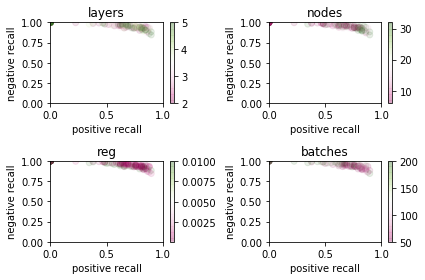

In [19]:
model_comparison_plots(baseline_results)

The results for the baseline model are not bad. We see that the models with the best positive recall have about an 88% positive recall rate and have up to a 93% negative recall. The model with the best accuracy rate and lowest entropy has 93% accuracy with 86% positive recall and 95% negative recall. There are a few models with a perfect negative recall rate but all of these are just guessing that every entry isn't an article which results in an 80% accuracy. There is an apparent trade off between positive recall and negative recall. In the plots, we can see that most of these models have good negative recall but not so good positive recall. This reflects the imbalanced classes of our data.

### Up-Sampling the Minority Class

In this section I separated the 526 articles from the 1796 nonarticles. Then I randomly selected 1796 articles, with replacement, so that it matched the number of nonarticles. This balanced the number of entries for each class.

One of the primary worries with this technique is that upsampling the articles in the training set will make it easier to over fit the training data since it's creating duplicates. Additionally, randomly upsampling somewhat skews the data since it won't represent everything evenly. Although this effect diminishes as the sampling size gets larger.   

In [20]:
# separates the non-articles from the articles
train_notarticles = train[train.is_article == 0]
train_articles = train[train.is_article == 1]

print("Number of Non-Articles: ", len(train_notarticles))
print("Number of Articles: ", len(train_articles))
print("Proportion of Documents that are Articles: ", len(train_articles) / (len(train)))

Number of Non-Articles:  1796
Number of Articles:  526
Proportion of Documents that are Articles:  0.22652885443583118


In [21]:
# upsampling the artilces with replacement
uparticles = train_articles.sample(len(train_notarticles), replace = True, random_state = 123)
print("Number of Up-Sampled Articles: ", len(uparticles))
# recombinging the dataset
uptrain = train_notarticles.append(uparticles)
print("Total Number of Entries in Upsampled Training Data: ", len(uptrain))

Number of Up-Sampled Articles:  1796
Total Number of Entries in Upsampled Training Data:  3592


In [22]:
# this vectorizes the text data for each entry and creates a list where 
# each index is associated with a different word and  the number of occurences 
# of the word is the value
uptrain_vecs = vectorizer1.transform(uptrain['text'])

# normalizes the dataset
uptrain_vecs = normalize(uptrain_vecs)

In [23]:
print(uptrain_vecs.shape)

(3592, 102339)


In [24]:
up_results = model_group(
    train_vecs = uptrain_vecs,
    train_labs = uptrain["is_article"],
    valid_vecs = valid_vecs,
    valid_labs = valid["is_article"],
    try_layers = [2,3,4,5],
    try_nodes = [8,16,32,6],
    try_reg = [.01,.001,.0001],
    try_epochs = [10],
    try_batches = [50,100,200],
    loss_func = "binary_crossentropy",
    class_weight = None
)

up_results.to_csv("up_results.csv")

Models to Train:  144
Model  0 , Acc:  0.8827586206896552
Model  1 , Acc:  0.8517241379310345
Model  2 , Acc:  0.8310344827586207
Model  3 , Acc:  0.8827586206896552
Model  4 , Acc:  0.8310344827586207
Model  5 , Acc:  0.896551724137931
Model  6 , Acc:  0.9137931034482759
Model  7 , Acc:  0.9
Model  8 , Acc:  0.906896551724138
Model  9 , Acc:  0.8758620689655172
Model  10 , Acc:  0.8862068965517241
Model  11 , Acc:  0.8620689655172413
Model  12 , Acc:  0.903448275862069
Model  13 , Acc:  0.8931034482758621
Model  14 , Acc:  0.896551724137931
Model  15 , Acc:  0.896551724137931
Model  16 , Acc:  0.906896551724138
Model  17 , Acc:  0.9
Model  18 , Acc:  0.8379310344827586
Model  19 , Acc:  0.8896551724137931
Model  20 , Acc:  0.8586206896551725
Model  21 , Acc:  0.9
Model  22 , Acc:  0.906896551724138
Model  23 , Acc:  0.9137931034482759
Model  24 , Acc:  0.8896551724137931
Model  25 , Acc:  0.903448275862069
Model  26 , Acc:  0.906896551724138
Model  27 , Acc:  0.8689655172413793
Model 

In [25]:
best_models(up_results)

Model with Best Positive Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
72,4.0,8.0,0.01,10.0,50.0,1.0,0.0,0.2,12.339953
73,4.0,8.0,0.01,10.0,100.0,1.0,0.0,0.2,12.339953
108,5.0,8.0,0.01,10.0,50.0,1.0,0.0,0.2,12.339953


Model with Best Negative Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
110,5.0,8.0,0.010,10.0,200.0,0.0,1.0,0.8,3.066648
136,5.0,6.0,0.010,10.0,100.0,0.0,1.0,0.8,3.066648
140,5.0,6.0,0.001,10.0,200.0,0.0,1.0,0.8,3.066648


Model with Best Accuracy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
89,4.0,16.0,0.0001,10.0,200.0,0.810345,0.952586,0.924138,1.166690
114,5.0,8.0,0.0001,10.0,50.0,0.775862,0.961207,0.924138,1.166057


Model with Least Entropy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
114,5.0,8.0,0.0001,10.0,50.0,0.775862,0.961207,0.924138,1.166057


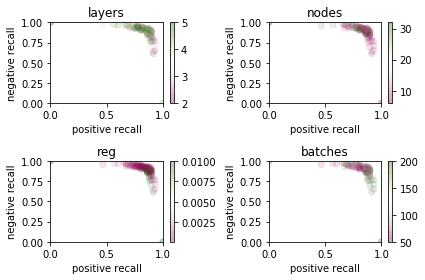

In [26]:
model_comparison_plots(up_results)

The clearest indication that the models with up-sampled data perform better is the scattering of the models on these positve/negative recall plots. We want to see models that are as close as possible to the upper right hand corner (the upper right hand corner represents 100% accuracy in both positive and negative recall and hence, perfect overall accuracy). It's clear that the average model in this group is closer than in the baseline model. Also, it's more balanced between positive and negative recall performance although that means many models had far worse negative recall than many of the models in the baseline. Also, there are a few models now that have positive recall. This is because they guessed everything is an article which results in a terrible accuracy score of 20%.  

### Down-Sampling the Majority Class

In this section I randomly selected 526 non articles, without replacement, so that it matched the number of articles. This balanced the number of entries for each class.

I didn't expect this technique to be very effective since it's essentially throwing away a lot of data. I expected it would reduce the negative recall rate much more than it would improve the positive recall rate.

In [27]:
# down sample nonarticles 
downnotarticles = train_notarticles.sample(len(train_articles), random_state = 123)
print("Number of Down-Sampled Not-Articles: ", len(downnotarticles))

# recombine the dataset
downtrain = train_articles.append(downnotarticles)
print("Total Number of Entries in Downsampled Training Data: ", len(downtrain))

Number of Down-Sampled Not-Articles:  526
Total Number of Entries in Downsampled Training Data:  1052


In [28]:
# this vectorizes the text data for each entry and creates a list where 
# each index is associated with a different word and  the number of occurences 
# of the word is the value
downtrain_vecs = vectorizer1.transform(downtrain['text'])

# normalizes the dataset
downtrain_vecs = normalize(downtrain_vecs)

In [29]:
print(downtrain_vecs.shape)

(1052, 102339)


In [30]:
down_results = model_group(
    train_vecs = downtrain_vecs,
    train_labs = downtrain["is_article"],
    valid_vecs = valid_vecs,
    valid_labs = valid["is_article"],
    try_layers = [2,3,4,5],
    try_nodes = [8,16,32,6],
    try_reg = [.01,.001,.0001],
    try_epochs = [10],
    try_batches = [50,100,200],
    loss_func = "binary_crossentropy",
    class_weight = None
)

down_results.to_csv("down_results.csv")

Models to Train:  144
Model  0 , Acc:  0.8310344827586207
Model  1 , Acc:  0.7172413793103448
Model  2 , Acc:  0.6137931034482759
Model  3 , Acc:  0.7344827586206897
Model  4 , Acc:  0.6758620689655173
Model  5 , Acc:  0.5586206896551724
Model  6 , Acc:  0.7724137931034483
Model  7 , Acc:  0.8413793103448276
Model  8 , Acc:  0.6896551724137931
Model  9 , Acc:  0.7620689655172413
Model  10 , Acc:  0.7068965517241379
Model  11 , Acc:  0.7862068965517242
Model  12 , Acc:  0.8448275862068966
Model  13 , Acc:  0.896551724137931
Model  14 , Acc:  0.7517241379310344
Model  15 , Acc:  0.8344827586206897
Model  16 , Acc:  0.8275862068965517
Model  17 , Acc:  0.8172413793103448
Model  18 , Acc:  0.8068965517241379
Model  19 , Acc:  0.7517241379310344
Model  20 , Acc:  0.7310344827586207
Model  21 , Acc:  0.8206896551724138
Model  22 , Acc:  0.8241379310344827
Model  23 , Acc:  0.7517241379310344
Model  24 , Acc:  0.8586206896551725
Model  25 , Acc:  0.8206896551724138
Model  26 , Acc:  0.8620689

In [31]:
best_models(down_results)

Model with Best Positive Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
108,5.0,8.0,0.010,10.0,50.0,1.0,0.000000,0.200000,12.339953
113,5.0,8.0,0.001,10.0,200.0,1.0,0.000000,0.200000,12.339953
135,5.0,6.0,0.010,10.0,50.0,1.0,0.064655,0.251724,11.542112


Model with Best Negative Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
63,3.0,6.0,0.0100,10.0,50.0,0.0,1.0,0.8,3.066648
67,3.0,6.0,0.0010,10.0,100.0,0.0,1.0,0.8,3.066648
110,5.0,8.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
114,5.0,8.0,0.0001,10.0,50.0,0.0,1.0,0.8,3.066648
126,5.0,32.0,0.0100,10.0,50.0,0.0,1.0,0.8,3.066648


Model with Best Accuracy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
48,3.0,16.0,0.001,10.0,50.0,0.793103,0.948276,0.917241,1.272753
76,4.0,8.0,0.001,10.0,100.0,0.775862,0.952586,0.917241,1.272436


Model with Least Entropy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
76,4.0,8.0,0.001,10.0,100.0,0.775862,0.952586,0.917241,1.272436


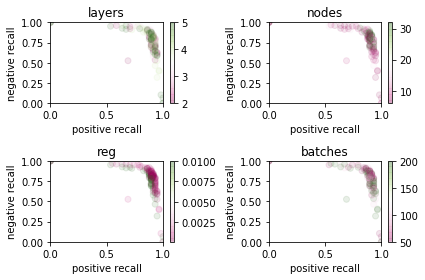

In [32]:
model_comparison_plots(down_results)

Unsurprisingly, this technique didn't perform very well because we already had very little data and decreasing the data further made it even more difficult to correctly predict for nonarticles. This technique seems more reasonable when you have more data than you need. We can see in the scattering of models for the positive and negative recall rates that many of the models actually perform better on articles than nonarticles. This may indicate that, given more balanaced data, models may actually be better at predicing articles than nonarticles.  

### Changing the Performance Metric

In this section I created a custom loss function that used l1 loss with twice the weight for articles than non articles. This increases the reward/punishment for the models performance on articles relative to its performance on nonarticles. 

I chose to use l1 loss for this technique because I expect that there will be some outliers in the data. This is because we chose to label facebook posts and tweets that linked to news articles as articles. We did this because the research project is interested in tracing the spread of news on all platforms. However, it's likely that such documents will be mislabled with high certainty. In retrospect, I think it would be able to separate social media sites from the rest of the domains.

In [33]:
# this function is a custom loss function that uses l1 loss but weights articles twice that of non articles
# input: y_true is an array of labels, y_pred is an array of associated predictions
# output: returns an array of losses
def max_recall_loss(y_true, y_pred):
    diff = y_true - y_pred
    wghts = y_true * 3 - 1
    loss = diff * wghts
    return loss[:,0]

# This shows an example output where y ou can see the weight is double for articles
y_true = np.array([[0],[1],[0],[1]])
y_pred = np.array([[.8],[.2],[.2],[.8]])
max_recall_loss(y_true, y_pred)


array([0.8, 1.6, 0.2, 0.4])

In [34]:
recall_results = model_group(
    train_vecs = train_vecs,
    train_labs = train["is_article"],
    valid_vecs = valid_vecs,
    valid_labs = valid["is_article"],
    try_layers = [2,3,4,5],
    try_nodes = [8,16,32,6],
    try_reg = [.01,.001,.0001],
    try_epochs = [10],
    try_batches = [50,100,200],
    loss_func = max_recall_loss,
    class_weight = None
)

recall_results.to_csv("recall_results.csv")

Models to Train:  144
Model  0 , Acc:  0.8
Model  1 , Acc:  0.8655172413793103
Model  2 , Acc:  0.8
Model  3 , Acc:  0.8862068965517241
Model  4 , Acc:  0.8862068965517241
Model  5 , Acc:  0.8862068965517241
Model  6 , Acc:  0.906896551724138
Model  7 , Acc:  0.8862068965517241
Model  8 , Acc:  0.8724137931034482
Model  9 , Acc:  0.8620689655172413
Model  10 , Acc:  0.8
Model  11 , Acc:  0.8
Model  12 , Acc:  0.8862068965517241
Model  13 , Acc:  0.8931034482758621
Model  14 , Acc:  0.8896551724137931
Model  15 , Acc:  0.8793103448275862
Model  16 , Acc:  0.8862068965517241
Model  17 , Acc:  0.8689655172413793
Model  18 , Acc:  0.8448275862068966
Model  19 , Acc:  0.8896551724137931
Model  20 , Acc:  0.8689655172413793
Model  21 , Acc:  0.8689655172413793
Model  22 , Acc:  0.906896551724138
Model  23 , Acc:  0.8862068965517241
Model  24 , Acc:  0.9103448275862069
Model  25 , Acc:  0.9137931034482759
Model  26 , Acc:  0.9103448275862069
Model  27 , Acc:  0.8
Model  28 , Acc:  0.8
Model  

In [35]:
best_models(recall_results)

Model with Best Positive Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
34,2.0,6.0,0.0001,10.0,100.0,0.931034,0.698276,0.744828,3.934756


Model with Best Negative Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
0,2.0,8.0,0.0100,10.0,50.0,0.0,1.0,0.8,3.066648
2,2.0,8.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
10,2.0,16.0,0.0100,10.0,100.0,0.0,1.0,0.8,3.066648
11,2.0,16.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
27,2.0,6.0,0.0100,10.0,50.0,0.0,1.0,0.8,3.066648
28,2.0,6.0,0.0100,10.0,100.0,0.0,1.0,0.8,3.066648
29,2.0,6.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
31,2.0,6.0,0.0010,10.0,100.0,0.0,1.0,0.8,3.066648
32,2.0,6.0,0.0010,10.0,200.0,0.0,1.0,0.8,3.066648
36,3.0,8.0,0.0100,10.0,50.0,0.0,1.0,0.8,3.066648


Model with Best Accuracy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
52,3.0,16.0,0.0001,10.0,100.0,0.810345,0.952586,0.924138,1.16669
98,4.0,32.0,0.0001,10.0,200.0,0.810345,0.952586,0.924138,1.16669


Model with Least Entropy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
52,3.0,16.0,0.0001,10.0,100.0,0.810345,0.952586,0.924138,1.16669
98,4.0,32.0,0.0001,10.0,200.0,0.810345,0.952586,0.924138,1.16669


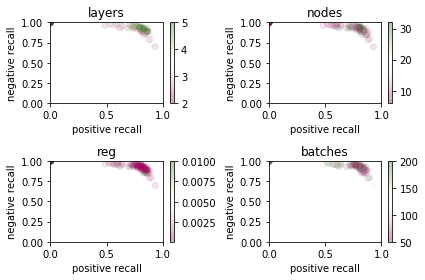

In [36]:
model_comparison_plots(recall_results)

I was suprised to see that many of these models still had very high negative recall rates without much improvement in their positive recall rates (although still better than the baseline models). This is probably because the data is imbalanced at a ratio of 3.4 to 1 while I only doubled the weight of articles by 2. Therefore, the custom loss function doesn't totally makeup for the imbalanced dataset. 

### Cost-Sensitive Training

In this section, I balance the weight of the article and nonarticle classes by increasing the weight of articles by the ratio of non articles to articles. This increase the loss cost for articles by about 3.4 times.

My primary worry about this technique is that it is likely to result in overfitting of the article training data since all the peculiarities of the articles in the training set are multiplied by 3.4 times. However, I think it's an improvement over the upsampling since it doesn't randomly sample articles. 

In [37]:
ratio = len(train_notarticles) / len(train_articles)

print("Ratio of Not-Articles to Articles: ", ratio)

# this dictionary maps 0 (i.e. nonarticles) to a wieght of 1 while
# mapping 1 (i.e. articles) to the ratio of nonarticles to articles
balanced_weight = {0: 1.,
                1: ratio}

Ratio of Not-Articles to Articles:  3.414448669201521


In [38]:
balanced_results = model_group(
    train_vecs = train_vecs,
    train_labs = train["is_article"],
    valid_vecs = valid_vecs,
    valid_labs = valid["is_article"],
    try_layers = [2,3,4,5],
    try_nodes = [8,16,32,6],
    try_reg = [.01,.001,.0001],
    try_epochs = [10],
    try_batches = [50,100,200],
    loss_func = "binary_crossentropy",
    class_weight = balanced_weight
)

balanced_results.to_csv("balanced_results.csv")

Models to Train:  144
Model  0 , Acc:  0.8724137931034482
Model  1 , Acc:  0.7620689655172413
Model  2 , Acc:  0.8758620689655172
Model  3 , Acc:  0.8724137931034482
Model  4 , Acc:  0.8275862068965517
Model  5 , Acc:  0.8551724137931035
Model  6 , Acc:  0.9
Model  7 , Acc:  0.8655172413793103
Model  8 , Acc:  0.903448275862069
Model  9 , Acc:  0.8655172413793103
Model  10 , Acc:  0.8448275862068966
Model  11 , Acc:  0.8310344827586207
Model  12 , Acc:  0.8310344827586207
Model  13 , Acc:  0.9
Model  14 , Acc:  0.8758620689655172
Model  15 , Acc:  0.903448275862069
Model  16 , Acc:  0.903448275862069
Model  17 , Acc:  0.8827586206896552
Model  18 , Acc:  0.8206896551724138
Model  19 , Acc:  0.8827586206896552
Model  20 , Acc:  0.8655172413793103
Model  21 , Acc:  0.8896551724137931
Model  22 , Acc:  0.8655172413793103
Model  23 , Acc:  0.9103448275862069
Model  24 , Acc:  0.896551724137931
Model  25 , Acc:  0.8827586206896552
Model  26 , Acc:  0.896551724137931
Model  27 , Acc:  0.8310

In [39]:
best_models(balanced_results)

Model with Best Positive Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
110,5.0,8.0,0.01,10.0,200.0,1.0,0.0,0.2,12.339953
137,5.0,6.0,0.01,10.0,200.0,1.0,0.0,0.2,12.339953


Model with Best Negative Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
73,4.0,8.0,0.010,10.0,100.0,0.0,1.0,0.8,3.066648
99,4.0,6.0,0.010,10.0,50.0,0.0,1.0,0.8,3.066648
108,5.0,8.0,0.010,10.0,50.0,0.0,1.0,0.8,3.066648
111,5.0,8.0,0.001,10.0,50.0,0.0,1.0,0.8,3.066648
136,5.0,6.0,0.010,10.0,100.0,0.0,1.0,0.8,3.066648


Model with Best Accuracy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
118,5.0,16.0,0.01,10.0,100.0,0.741379,0.965517,0.92069,1.218614


Model with Least Entropy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
118,5.0,16.0,0.01,10.0,100.0,0.741379,0.965517,0.92069,1.218614


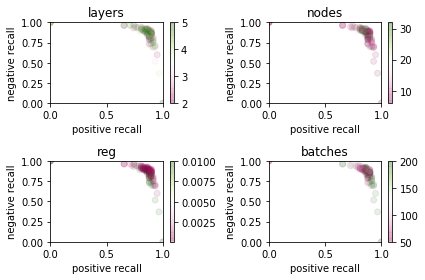

In [40]:
model_comparison_plots(balanced_results)

This appears to be the best set of models so far since, as can be seen on the neg/pos recall plots, it's both balanced between positive and negative recall and as close to the upper right hand corner as we've seen so far. This indicates that cost-sensitive training is the most effective method for balancing the dataset. This is probably because it utilizes all the available data, doesn't have to randomly sample, and fully corrects for the imbalance in the data. 

### Create Word Vectors for the Domain and URL

In the following two sections, I vectorize the domain and url features of the data in order to incoporate them into our neural net models. After having decided that the best way to balance the data was using the cost-sensitive training technique, I had both of the following models utilize it. 

In [41]:
# creates word count vectors with url vectors appended for train, valid, and test sets
url_vectorizer2 = CountVectorizer(stop_words = url_stops).fit(data["url"]) 
train_vecs_url = url_vectorizer2.transform(train["url"]) 
train_vecs_url = hstack([train_vecs, train_vecs_url]).toarray()
valid_vecs_url = url_vectorizer2.transform(valid["url"]) 
valid_vecs_url = hstack([valid_vecs, valid_vecs_url]).toarray()
test_vecs_url = url_vectorizer2.transform(test["url"]) 
test_vecs_url = hstack([test_vecs, test_vecs_url]).toarray()

# creates word count vectors with domain vectors appended for train, valid, and test sets
dom_vectorizer2 = CountVectorizer(stop_words = dom_stops).fit(data["domain"])
train_vecs_dom = dom_vectorizer2.transform(train["domain"])
train_vecs_dom = hstack([train_vecs, train_vecs_dom]).toarray()
valid_vecs_dom = dom_vectorizer2.transform(valid["domain"]) 
valid_vecs_dom = hstack([valid_vecs, valid_vecs_dom]).toarray()
test_vecs_dom = dom_vectorizer2.transform(test["domain"]) 
test_vecs_dom = hstack([test_vecs, test_vecs_dom]).toarray()

### URL Model

In [42]:
url_results = model_group(
    train_vecs = train_vecs_url,
    train_labs = train["is_article"],
    valid_vecs = valid_vecs_url,
    valid_labs = valid["is_article"],
    try_layers = [2,3,4,5],
    try_nodes = [8,16,32,6],
    try_reg = [.01,.001,.0001],
    try_epochs = [10],
    try_batches = [50,100,200],
    loss_func = "binary_crossentropy",
    class_weight = balanced_weight
)

url_results.to_csv("url_results.csv")

Models to Train:  144
Model  0 , Acc:  0.9206896551724137
Model  1 , Acc:  0.9172413793103448
Model  2 , Acc:  0.8827586206896552
Model  3 , Acc:  0.9206896551724137
Model  4 , Acc:  0.906896551724138
Model  5 , Acc:  0.903448275862069
Model  6 , Acc:  0.8896551724137931
Model  7 , Acc:  0.9241379310344827
Model  8 , Acc:  0.8931034482758621
Model  9 , Acc:  0.896551724137931
Model  10 , Acc:  0.9
Model  11 , Acc:  0.9
Model  12 , Acc:  0.9172413793103448
Model  13 , Acc:  0.9206896551724137
Model  14 , Acc:  0.9137931034482759
Model  15 , Acc:  0.9241379310344827
Model  16 , Acc:  0.9172413793103448
Model  17 , Acc:  0.9172413793103448
Model  18 , Acc:  0.8724137931034482
Model  19 , Acc:  0.906896551724138
Model  20 , Acc:  0.9137931034482759
Model  21 , Acc:  0.9103448275862069
Model  22 , Acc:  0.9206896551724137
Model  23 , Acc:  0.9206896551724137
Model  24 , Acc:  0.9
Model  25 , Acc:  0.9137931034482759
Model  26 , Acc:  0.9241379310344827
Model  27 , Acc:  0.8896551724137931
M

In [43]:
best_models(url_results)

Model with Best Positive Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
143,5.0,6.0,0.0001,10.0,200.0,1.0,0.0,0.2,12.339953


Model with Best Negative Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
138,5.0,6.0,0.001,10.0,50.0,0.0,1.0,0.8,3.066648


Model with Best Accuracy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
41,3.0,8.0,0.001,10.0,200.0,0.775862,0.974138,0.934483,1.006489


Model with Least Entropy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
41,3.0,8.0,0.001,10.0,200.0,0.775862,0.974138,0.934483,1.006489


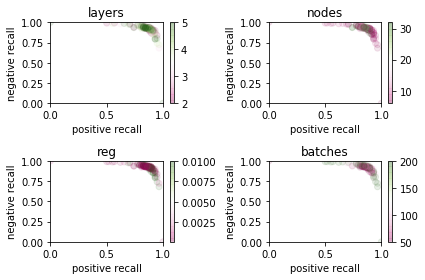

In [44]:
model_comparison_plots(url_results)

Adding the URL word vectors seems to have improved both the positive and negative recall, relative to the cost-sensitive training model with just document vectors. However, it does seem to be less balanced since the pos/neg recall plots have a tail trailing toward worse positive recall for the models with the best negative recall. However,Many of the models seem to be quite close to the upper right hand corner. 

### Domain Model

In [45]:
dom_results = model_group(
    train_vecs = train_vecs_dom,
    train_labs = train["is_article"],
    valid_vecs = valid_vecs_dom,
    valid_labs = valid["is_article"],
    try_layers = [2,3,4,5],
    try_nodes = [8,16,32,6],
    try_reg = [.01,.001,.0001],
    try_epochs = [10],
    try_batches = [50,100,200],
    loss_func = "binary_crossentropy",
    class_weight = balanced_weight
)

dom_results.to_csv("dom_results.csv")

Models to Train:  144
Model  0 , Acc:  0.8241379310344827
Model  1 , Acc:  0.8413793103448276
Model  2 , Acc:  0.8103448275862069
Model  3 , Acc:  0.8827586206896552
Model  4 , Acc:  0.8068965517241379
Model  5 , Acc:  0.8172413793103448
Model  6 , Acc:  0.8862068965517241
Model  7 , Acc:  0.896551724137931
Model  8 , Acc:  0.8793103448275862
Model  9 , Acc:  0.8896551724137931
Model  10 , Acc:  0.8413793103448276
Model  11 , Acc:  0.8448275862068966
Model  12 , Acc:  0.8724137931034482
Model  13 , Acc:  0.8896551724137931
Model  14 , Acc:  0.8862068965517241
Model  15 , Acc:  0.906896551724138
Model  16 , Acc:  0.8862068965517241
Model  17 , Acc:  0.8931034482758621
Model  18 , Acc:  0.8413793103448276
Model  19 , Acc:  0.7931034482758621
Model  20 , Acc:  0.8517241379310345
Model  21 , Acc:  0.8172413793103448
Model  22 , Acc:  0.8206896551724138
Model  23 , Acc:  0.8310344827586207
Model  24 , Acc:  0.8482758620689655
Model  25 , Acc:  0.8896551724137931
Model  26 , Acc:  0.84827586

In [46]:
best_models(dom_results)

Model with Best Positive Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
137,5.0,6.0,0.01,10.0,200.0,1.0,0.0,0.2,12.339953


Model with Best Negative Recall


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
110,5.0,8.0,0.0100,10.0,200.0,0.0,1.0,0.8,3.066648
142,5.0,6.0,0.0001,10.0,100.0,0.0,1.0,0.8,3.066648


Model with Best Accuracy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
88,4.0,16.0,0.0001,10.0,100.0,0.775862,0.943966,0.910345,1.378815
105,4.0,6.0,0.0001,10.0,50.0,0.793103,0.939655,0.910345,1.379131
106,4.0,6.0,0.0001,10.0,100.0,0.741379,0.952586,0.910345,1.378183


Model with Least Entropy


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
106,4.0,6.0,0.0001,10.0,100.0,0.741379,0.952586,0.910345,1.378183


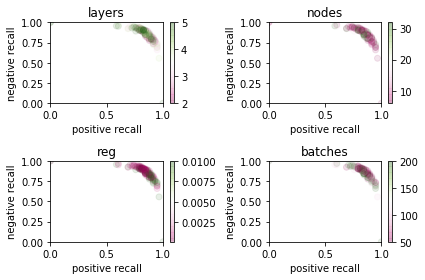

In [47]:
model_comparison_plots(dom_results)

Including the domain vectors seems to keep the models more balanced then when we add the url vectors but they're clearly farther away from the upper right hand corner of the pos/neg recall plots. I think this indicates that parts of the url like "login" are better indicators of whether or not a document is an article then just the domain.

### Take a Closer Look at Top Model

In this section I take the average parameterizations of the models from the URL model group that fit minimal requirements of at least a .85 positive recall rate and at most a 1.5 binary crossentropy score and consider them to be the parameterization for my "top model" in the sense that they're most likely to result in the best performing model. 

I don't want to just take the the parameterization of the model with the best combination of positive recall and entropy because these models are highly sensitive to the randomness introduced while training them due to the small amount of data. Therefore, it's possible that any particular model just got lucky and ended up with really good performance results. Therefore, I take the average to reduce this uncertainty. I wouldn't expect this model to do as well as the best models in my grid search but it shouldn't be significantly worse.

In [48]:
top_models = url_results[(url_results.precall > .85) & (url_results.entropy < 1.5)].sort_values("entropy")
print("Number of Best Models: ", len(top_models))
top_models.iloc[0:10]

Number of Best Models:  59


,layers,nodes,reg,epochs,batches,precall,nrecall,accuracy,entropy
122,5.0,16.0,0.0010,10.0,200.0,0.879310,0.943966,0.931034,1.061576
59,3.0,32.0,0.0010,10.0,200.0,0.862069,0.943966,0.927586,1.114449
15,2.0,16.0,0.0001,10.0,50.0,0.862069,0.939655,0.924138,1.167639
52,3.0,16.0,0.0001,10.0,100.0,0.862069,0.939655,0.924138,1.167639
127,5.0,32.0,0.0100,10.0,100.0,0.879310,0.935345,0.924138,1.167955
106,4.0,6.0,0.0001,10.0,100.0,0.896552,0.931034,0.924138,1.168271
121,5.0,16.0,0.0010,10.0,100.0,0.862069,0.935345,0.920690,1.220828
81,4.0,16.0,0.0100,10.0,50.0,0.862069,0.935345,0.920690,1.220828
67,3.0,6.0,0.0010,10.0,100.0,0.862069,0.935345,0.920690,1.220828
22,2.0,32.0,0.0010,10.0,100.0,0.862069,0.935345,0.920690,1.220828


In [49]:
avg_params = top_models.mean()
display(avg_params)

layers        3.305085
nodes        15.728814
reg           0.004036
epochs       10.000000
batches     105.932203
precall       0.881648
nrecall       0.922633
accuracy      0.914436
entropy       1.317649
dtype: float64

In [50]:
top_model = model_maker(
        n_layers = int(avg_params["layers"].round()),
        n_nodes = int(avg_params["nodes"].round()),
        reg = avg_params["reg"],
        in_shape = (train_vecs_url.shape[1],),
        loss_func = "binary_crossentropy")

top_model.summary()

Model: "sequential_1009"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5545 (Dense)           (None, 16)                1785664   
_________________________________________________________________
dense_5546 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_5547 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_5548 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_5549 (Dense)           (None, 1)                 17        
Total params: 1,786,497
Trainable params: 1,786,497
Non-trainable params: 0
_________________________________________________________________


Train on 2322 samples, validate on 290 samples
Epoch 1/10
2322/2322 [==============================] - 11s 5ms/step - loss: 1.1704 - accuracy: 0.8312 - val_loss: 0.6880 - val_accuracy: 0.8966
Epoch 2/10
2322/2322 [==============================] - 4s 2ms/step - loss: 0.9210 - accuracy: 0.9401 - val_loss: 0.5532 - val_accuracy: 0.8966
Epoch 3/10
2322/2322 [==============================] - 4s 2ms/step - loss: 0.7165 - accuracy: 0.9509 - val_loss: 0.4664 - val_accuracy: 0.9138
Epoch 4/10
2322/2322 [==============================] - 4s 2ms/step - loss: 0.5511 - accuracy: 0.9578 - val_loss: 0.4755 - val_accuracy: 0.8931
Epoch 5/10
2322/2322 [==============================] - 4s 2ms/step - loss: 0.4357 - accuracy: 0.9681 - val_loss: 0.4411 - val_accuracy: 0.9138
Epoch 6/10
2322/2322 [==============================] - 4s 2ms/step - loss: 0.3644 - accuracy: 0.9772 - val_loss: 0.4013 - val_accuracy: 0.9276
Epoch 7/10
2322/2322 [==============================] - 4s 2ms/step - loss: 0.3206 - acc

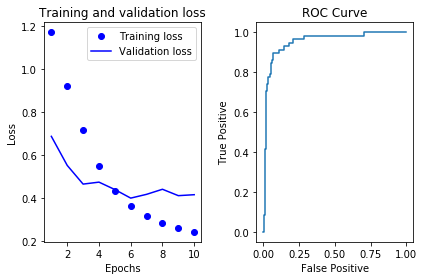

In [51]:
top_history = top_model.fit(
        train_vecs_url,
        train["is_article"],
        epochs = int(avg_params["epochs"].round()),
        batch_size = int(avg_params["batches"].round()),
        class_weight = balanced_weight,
        validation_data=(valid_vecs_url, valid["is_article"]))

valid_scores = evaluate(top_history, valid_vecs_url, valid["is_article"])

In [52]:
print("Positive Recall on Valid Dataset: ", valid_scores[0])
print("Negative Recall on Valid Dataset: ", valid_scores[1])
print("Accuracy on Valid Dataset: ", valid_scores[2])
print("Entropy on Valid Dataset: ", valid_scores[3])

Positive Recall on Valid Dataset:  0.8620689655172413
Negative Recall on Valid Dataset:  0.9353448275862069
Accuracy on Valid Dataset:  0.9206896551724137
Entropy on Valid Dataset:  1.220828


This model ended up performing decently on the validation set with a 90% positive recall, 92% negative recall, 91% overall accuracy and 1.33 binary cross entropy score. However, the model is still highly sensitive to the randomnes introduced by the training and so I cannot be confident about its performance. 

Positive Recall on Test Dataset:  0.8591549295774648
Negative Recall on Test Dataset:  0.9363636363636364
Accuracy on Test Dataset:  0.9175257731958762
Entropy on Test Dataset:  1.2690092


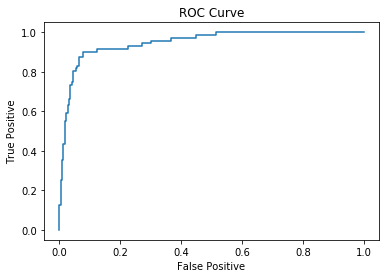

In [53]:
roc_plot(top_history, test_vecs_url, test["is_article"])
test_scores = precall_nrecall_acc_entropy(top_history, test_vecs_url, test["is_article"])
print("Positive Recall on Test Dataset: ", test_scores[0])
print("Negative Recall on Test Dataset: ", test_scores[1])
print("Accuracy on Test Dataset: ", test_scores[2])
print("Entropy on Test Dataset: ", test_scores[3])

The performance of this model on the test set is similar to its performance on the validation set with a 89% positive recall, 90% negative recall, 90% overall accuracy and 1.53 binary cross entropy score. It does seem like it performed slightly worse, especially in terms of entropy, but that's to be expected when testing so many different models and evaluating them based on their performance on the validation set. Additionally, the ROC curve is pretty good since it hugs relatively tightly to the upper left hand corner of the graph. 

## Results

The main takeaways from this project are that cost-sensitive training and incorporating URLs are the most effective methods for improving the neural net's performance, out of the approaches tried here. However, the best thing would be to get more labeled data as all of these models are highly sensitve to the randomness introduced by training. With more data, it's more likely that these models could consistently converage to a model that has better overall performance. 

There are a few things that I could have done differently, in retrospect. I think it would've been better to use a custom loss function that fully corrected for the imbalanced classes by weighting the articles at 3.4 times that of nonarticles. I think this would have resulted in a better positive recall for that model group. Additionally, it may be helpful to separate out social media domains from news source domains as these are significantly different groups. However, given the current amount of data, removing all social media entries would result in a very small sample size. Therefore, the best thing to do would really be to label more data. 

I will be continuing to work on this project over the summer as Professor Holcomb's research assistant so I have a few ideas for what to do next. I think it would be worthwhile to bite the bullet and try to classify another 1000 or 2000 documents as either an article or nonarticle. Additionally, I think it will be instructive to take a deeper look at how these models misclassify the documents. Finding patterns in their misclassification may reveal how to correct for them. Additionally, I will try and extract all of the non-text data (i.e. date, domain, url) and explore what the real frequency of different domains are and other exploratory data analysis.  

## Implications

I think it's important in this project that I'm able to increase the positive recall as much as possible. Doing so will reduce the risk of biasedly omitting part of the data for studying the News Ecosystem in New Jersey. For instance, this dataset contains a few different languages including Spanish, Chinese, and Korean, besides English. However, this is a small minority of the documents. Also, many of these such as Arabic are most commonly found in tweets which are usually labeled as nonarticles. On the otherhand, there are a few news outlets that produce articles in other languages such as Spanish and Chinese. However, there are very few of these in our 3000 document sample. Therefore, it's likely that the the classifier will biasedly label minority language news articles as nonarticles. If this is allowed to happen then in the future studies of New Jersey's News Ecosystem, minority language news will be underrepresented which could contribute to systematic biases and injustices. 

I believe that correcting for the imbalanced data and incorporating URL and Domain features has brought me closer to minimizing such misclassifications. Hopefully, I'm able to produce a classifier that is able to identify most of the news articles without biasedly omitting some.

## Bibliography

EliteDataScience, "How to Handle Imbalanced Classes in Machine Learning" https://elitedatascience.com/imbalanced-classes

Sci-kit Learn, "sklearn.feature_extraction.text.CountVectorizer" https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Vander Linden, Keith. "An Introduction to Keras" https://github.com/kvlinden-courses/cs344-code/blob/master/u08features/keras-mnist.ipynb (2020)